# Semi Supervised Learning SSL

## Introduction

In this project, we delve into the challenges of semi-supervised learning (SSL) and its application to address label scarcity in classification tasks. The dataset used in this project, the Magic Mushrooms dataset, contains features related to mushroom characteristics, previously explored in assignments 1 and 2.

The primary objective is to investigate how semi-supervised learning can leverage a small amount of labeled data alongside a larger portion of unlabeled data to improve classification performance. We begin by building a supervised learning baseline using the Gradient Boosting algorithm. This serves as a benchmark against which the performance of various semi-supervised algorithms will be compared.

To start the virtual enviornment, run "source py-env/bin/activate"

## Libraries Installed

In [169]:
import ssl
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import optuna

## Data Preprocessing

In [170]:
# Disable SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

# Fetch dataset
drug_consumption_quantified = fetch_ucirepo(id=373)

# Data as pandas DataFrames
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

# Convert features and targets into a single DataFrame
df = pd.concat([X, y], axis=1)

user_data = df.iloc[:, 0:12]


choco = df['choc']
shrooms = df['mushrooms']


In [121]:
# take the multiple classifications and convert it into binary
mushrooms_binary = []

for i in shrooms:
    if i == 'CL0' or i == 'CL1':
        mushrooms_binary.append(0)
    else:
        mushrooms_binary.append(1)

mushrooms_binary = np.array(mushrooms_binary)

X_mushroom_train, X_mushroom_test, y_mushroom_train, y_mushroom_test = train_test_split(user_data, mushrooms_binary, test_size=0.33, random_state=42, stratify=mushrooms_binary)

In [172]:
X_mushroom_train.shape

(1262, 12)

In [173]:
# model eval function
def evaluate_model(type, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{model.__class__.__name__} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    ax.set_title(f"{type} Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    
    return accuracy, y_pred

## Supervised Learning Baseline
- Implementing the Gradient Boosting model
- Hyperparameter optimization (Bayesian Search via Optuna)
- Performance metrics (accuracy, precision, recall, F1-score, AUC)

[I 2024-12-02 16:31:27,912] A new study created in memory with name: no-name-6ba806be-fc24-4e92-80d1-5762f71948d1
[I 2024-12-02 16:31:28,207] Trial 0 finished with value: 0.7718112805069326 and parameters: {'n_estimators': 74, 'learning_rate': 0.241066773774347, 'max_depth': 2}. Best is trial 0 with value: 0.7718112805069326.
[I 2024-12-02 16:31:28,480] Trial 1 finished with value: 0.7670713344626388 and parameters: {'n_estimators': 103, 'learning_rate': 0.010137597959908116, 'max_depth': 1}. Best is trial 0 with value: 0.7718112805069326.
[I 2024-12-02 16:31:28,850] Trial 2 finished with value: 0.7805320283581152 and parameters: {'n_estimators': 163, 'learning_rate': 0.018558325172528534, 'max_depth': 1}. Best is trial 2 with value: 0.7805320283581152.
[I 2024-12-02 16:31:29,447] Trial 3 finished with value: 0.7813288161114247 and parameters: {'n_estimators': 117, 'learning_rate': 0.03565800263964424, 'max_depth': 3}. Best is trial 3 with value: 0.7813288161114247.
[I 2024-12-02 16:31

Best parameters: {'n_estimators': 125, 'learning_rate': 0.01320744206815179, 'max_depth': 3}
Best cross-validation accuracy: 0.7932147562582343
GradientBoostingClassifier - Accuracy: 0.7431781701444623, Precision: 0.6589861751152074, Recall: 0.6244541484716157


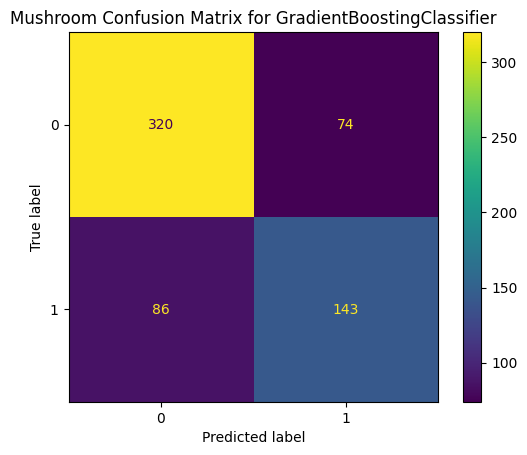

In [174]:

# Define the objective function for optimization
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Number of trees
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)  # Learning rate
    max_depth = trial.suggest_int('max_depth', 1, 5)  # Maximum depth of each tree

    # Create the model with suggested hyperparameters
    model = GradientBoostingClassifier(n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,random_state=0)
    
    # Evaluate the model using cross-validation
    scores = cross_val_score(model, X_mushroom_train, y_mushroom_train, cv=5, scoring='accuracy')
    
    # Return the mean cross-validation accuracy
    return scores.mean()

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials

# Print the best hyperparameters and their performance
print(f"Best parameters: {study.best_params}")
print(f"Best cross-validation accuracy: {study.best_value}")

# Retrieve the best model
best_params = study.best_params
best_model = GradientBoostingClassifier(**best_params, random_state=0)
y_pred = evaluate_model("Mushroom", best_model, X_mushroom_train, y_mushroom_train, X_mushroom_test, y_mushroom_test)

## ROC Curves for Mushrooms

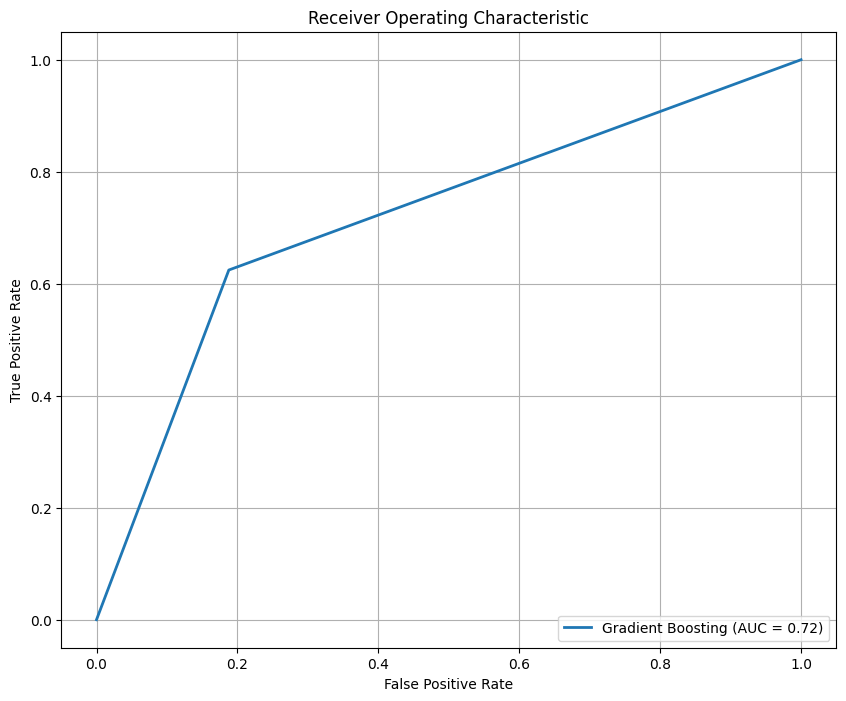

In [175]:
# Create a figure for the ROC curve
plt.figure(figsize=(10, 8))

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, linewidth=2, label=label)

# List of classifiers and their predictions
models = {
    "Gradient Boosting": y_pred[1]
}

# Loop through each model to calculate and plot ROC curves
for name, predictions in models.items():
    # Use predict_proba for SVM and others that support it
    y_pred_proba = predictions  # For other models, use the predicted classes

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_mushroom_test, y_pred_proba)
    roc_auc = roc_auc_score(y_mushroom_test, y_pred_proba)
    plot_roc_curve(fpr, tpr, f"{name} (AUC = {roc_auc:.2f})")

# Finalize the ROC curve plot
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## A. Semi-Supervised Learning

### Spliting Data into Labeled and Unlabeled

In [176]:
num_samples = len(y_mushroom_train)
num_labeled = int(0.1 * num_samples)
labeled_indices = np.random.choice(num_samples, num_labeled, replace=False)

y_mushroom_train_unlabeled = np.full_like(y_mushroom_train, fill_value=-1)
y_mushroom_train_unlabeled[labeled_indices] = y_mushroom_train[labeled_indices]

print(f"Total samples: {num_samples}")
print(f"Labeled samples: {np.sum(y_mushroom_train_unlabeled != -1)}")
print(f"Unlabeled samples: {np.sum(y_mushroom_train_unlabeled == -1)}")

Total samples: 1262
Labeled samples: 126
Unlabeled samples: 1136


### Self-Training with Gradient Boosting

In [177]:
self_training_model = SelfTrainingClassifier(GradientBoostingClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=0))

self_training_model.fit(X_mushroom_train, y_mushroom_train_unlabeled)

# Train the self-training model and evaluate its performance
y_pred = self_training_model.predict(X_mushroom_test)
accuracy = accuracy_score(y_mushroom_test, y_pred)

print(f"Accuracy of Self-Training with Gradient Boosting: {accuracy:.4f}")

Accuracy of Self-Training with Gradient Boosting: 0.6822


### Co-training with Gradient Boosting

In [178]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X_mushroom_train, y_mushroom_train, test_size=0.9, stratify=y_mushroom_train
)

num_features = X_labeled.shape[1]
X_labeled_view1, X_labeled_view2 = X_labeled.iloc[:, :num_features // 2], X_labeled.iloc[:, num_features // 2:]
X_unlabeled_view1, X_unlabeled_view2 = X_unlabeled.iloc[:, :num_features // 2], X_unlabeled.iloc[:, num_features // 2:]

In [179]:
studyOne = optuna.create_study(direction='maximize')  
studyOne.optimize(objective, n_trials=50)  
best_paramsOne = studyOne.best_params
clf1 = GradientBoostingClassifier(**best_paramsOne, random_state=0)

studyTwo = optuna.create_study(direction='maximize')  
studyTwo.optimize(objective, n_trials=50) 
best_paramsTwo = studyTwo.best_params
clf2 = GradientBoostingClassifier(**best_paramsTwo, random_state=0)

clf1.fit(X_labeled_view1, y_labeled)
clf2.fit(X_labeled_view2, y_labeled)

max_iterations = 10
confidence_threshold = 0.9

X_unlabeled_view1 = X_unlabeled_view1.reset_index(drop=True)
X_unlabeled_view2 = X_unlabeled_view2.reset_index(drop=True)

# Co-training loop
for iteration in range(max_iterations):
    print(f"--- Iteration {iteration + 1} ---")
    
    # Step 1: Predict on the unlabeled data using both classifiers
    probs1 = clf1.predict_proba(X_unlabeled_view1)
    probs2 = clf2.predict_proba(X_unlabeled_view2)

    # Step 2: Select confident predictions (probability > confidence_threshold)
    confident_indices1 = np.where(np.max(probs1, axis=1) > confidence_threshold)[0]
    confident_indices2 = np.where(np.max(probs2, axis=1) > confidence_threshold)[0]

    # Ensure consistent indices by using `.iloc` only within bounds
    if confident_indices1.size > 0:
        confident_samples1_view1 = X_unlabeled_view1.iloc[confident_indices1]
        confident_samples1_view2 = X_unlabeled_view2.iloc[confident_indices1]
        confident_labels1 = clf1.predict(confident_samples1_view1)

        X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples1_view1], axis=0)
        X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples1_view2], axis=0)
        y_labeled = np.hstack((y_labeled, confident_labels1))

    if confident_indices2.size > 0:
        confident_samples2_view1 = X_unlabeled_view1.iloc[confident_indices2]
        confident_samples2_view2 = X_unlabeled_view2.iloc[confident_indices2]
        confident_labels2 = clf2.predict(confident_samples2_view2)

        X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples2_view1], axis=0)
        X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples2_view2], axis=0)
        y_labeled = np.hstack((y_labeled, confident_labels2))

    # Step 3: Remove confident samples from the unlabeled set
    confident_indices_combined = np.union1d(confident_indices1, confident_indices2)
    X_unlabeled_view1 = X_unlabeled_view1.drop(index=confident_indices_combined).reset_index(drop=True)
    X_unlabeled_view2 = X_unlabeled_view2.drop(index=confident_indices_combined).reset_index(drop=True)

    # Retrain classifiers on the updated labeled set
    clf1.fit(X_labeled_view1, y_labeled)
    clf2.fit(X_labeled_view2, y_labeled)

    # Step 4: Stop if no confident predictions
    if confident_indices1.size == 0 and confident_indices2.size == 0:
        print("No more confident predictions; stopping training.")
        break

    print(f"Added {len(confident_indices1) + len(confident_indices2)} new labeled samples.")

# Final evaluation on test set
probs1_test = clf1.predict_proba(X_mushroom_test.iloc[:, :num_features // 2])  # First view
probs2_test = clf2.predict_proba(X_mushroom_test.iloc[:, num_features // 2:])  # Second view

# Average the probabilities from both classifiers
avg_probs_test = (probs1_test + probs2_test) / 2

# Convert averaged probabilities to predicted labels
final_predictions = np.argmax(avg_probs_test, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(y_mushroom_test, final_predictions)
print(f"Final accuracy on test set: {accuracy:.4f}")


[I 2024-12-02 16:32:09,769] A new study created in memory with name: no-name-b51f3529-8053-4b98-8425-0daa306e583f
[I 2024-12-02 16:32:10,572] Trial 0 finished with value: 0.7860813099943534 and parameters: {'n_estimators': 198, 'learning_rate': 0.011319473651413704, 'max_depth': 2}. Best is trial 0 with value: 0.7860813099943534.
[I 2024-12-02 16:32:11,944] Trial 1 finished with value: 0.7464991530208922 and parameters: {'n_estimators': 200, 'learning_rate': 0.46042941421656813, 'max_depth': 4}. Best is trial 0 with value: 0.7860813099943534.
[I 2024-12-02 16:32:12,645] Trial 2 finished with value: 0.7353692201518289 and parameters: {'n_estimators': 77, 'learning_rate': 0.9336042767028181, 'max_depth': 5}. Best is trial 0 with value: 0.7860813099943534.
[I 2024-12-02 16:32:13,273] Trial 3 finished with value: 0.7686586360499403 and parameters: {'n_estimators': 117, 'learning_rate': 0.1976247760670793, 'max_depth': 3}. Best is trial 0 with value: 0.7860813099943534.
[I 2024-12-02 16:32:

--- Iteration 1 ---
Added 667 new labeled samples.
--- Iteration 2 ---
Added 271 new labeled samples.
--- Iteration 3 ---
Added 97 new labeled samples.
--- Iteration 4 ---
Added 25 new labeled samples.
--- Iteration 5 ---
Added 7 new labeled samples.
--- Iteration 6 ---
Added 6 new labeled samples.
--- Iteration 7 ---
Added 4 new labeled samples.
--- Iteration 8 ---
Added 1 new labeled samples.
--- Iteration 9 ---
Added 4 new labeled samples.
--- Iteration 10 ---
Added 1 new labeled samples.
Final accuracy on test set: 0.6886


### Semi-supervised ensemble

In [180]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X_mushroom_train, y_mushroom_train, test_size=0.9, stratify=y_mushroom_train
)

In [181]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class SemiBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, beta=1.0):
        self.base_estimator = base_estimator or DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.beta = beta

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        X_labeled, y_labeled = check_X_y(X_labeled, y_labeled)
        X_unlabeled = check_array(X_unlabeled)

        self.classes_ = np.unique(y_labeled)
        n_labeled = X_labeled.shape[0]
        n_unlabeled = X_unlabeled.shape[0]

        X_combined = np.vstack((X_labeled, X_unlabeled))
        y_combined = np.hstack((y_labeled, [-1] * n_unlabeled))

        weights = np.ones(n_labeled + n_unlabeled) / (n_labeled + n_unlabeled)

        self.estimators_ = []
        self.estimator_weights_ = []

        for _ in range(self.n_estimators):
            clf = self.base_estimator
            clf.fit(X_combined, y_combined, sample_weight=weights)

            y_pred = clf.predict(X_combined)

            labeled_error = np.sum(weights[:n_labeled] * (y_pred[:n_labeled] != y_labeled)) / np.sum(weights[:n_labeled])

            weights[:n_labeled] *= np.exp(self.beta * (y_pred[:n_labeled] != y_labeled))

            confident_predictions = np.abs(clf.predict_proba(X_unlabeled).max(axis=1) - 0.5) > 0.3
            pseudo_labels = clf.predict(X_unlabeled)
            weights[n_labeled:] *= np.exp(self.beta * confident_predictions * (pseudo_labels != y_combined[n_labeled:]))

            weights /= np.sum(weights)

            self.estimators_.append(clf)
            self.estimator_weights_.append(np.log(1 / labeled_error))

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        final_prediction = np.zeros(X.shape[0])
        for weight, clf in zip(self.estimator_weights_, self.estimators_):
            final_prediction += weight * clf.predict(X)

        return np.sign(final_prediction)


In [182]:
semi_boost = SemiBoost(n_estimators=10)
semi_boost.fit(X_labeled, y_labeled, X_unlabeled)


y_pred = semi_boost.predict(X_mushroom_test)
accuracy = accuracy_score(y_mushroom_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.57


### Unsupervised pretraining

In [183]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Train an autoencoder using MLPRegressor
autoencoder = MLPRegressor(hidden_layer_sizes=(50, 25, 50), max_iter=500, random_state=42)
autoencoder.fit(X_unlabeled, X_unlabeled)

# Extract encoded features
encoder = autoencoder
X_labeled_encoded = encoder.predict(X_labeled)
X_unlabeled_encoded = encoder.predict(X_unlabeled)
X_test_encoded = encoder.predict(X_mushroom_test)

# Train a classifier on the labeled data with encoded features
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_labeled_encoded, y_labeled)

# Evaluate the model on the test set
y_pred = clf.predict(X_test_encoded)
accuracy = accuracy_score(y_mushroom_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_mushroom_test, y_pred, average="binary")
auc = roc_auc_score(y_mushroom_test, clf.predict_proba(X_test_encoded)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Accuracy: 0.7223
Precision: 0.6505, Recall: 0.5284, F1-score: 0.5831
AUC: 0.7623


### Part B: Evaluation of Results

In [206]:
# important: we will reuse X_mushroom_train, X_mushroom_test, y_mushroom_train, y_mushroom_test for final evaluation
# split the dataset into labeled and unlabeled data, we will use 10/90, 20/80, 30/70, 40/60, 50/50 splits, use num_samples for the total number of samples

# all four models redefined:

def self_training_gradient_boosting(y_mushroom_train_unlabeled, split_ratio):
    self_training_model = SelfTrainingClassifier(GradientBoostingClassifier(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=0))
    self_training_model.fit(X_mushroom_train, y_mushroom_train_unlabeled)

    # Train the self-training model and evaluate its performance
    y_pred = self_training_model.predict(X_mushroom_test)
    accuracy = accuracy_score(y_mushroom_test, y_pred)
    labeled_percentage = int((1 - split_ratio) * 100)
    unlabeled_percentage = int(split_ratio * 100)

    print(f"Accuracy of Self-Training with Gradient Boosting with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.2f}")

    # return the precision, recall, F1-score, and area under the ROC curve (AUC).

def co_training_gradient_boosting(X_labeled, X_unlabeled, y_labeled, split_ratio):
    
    num_features = X_labeled.shape[1]
    X_labeled_view1, X_labeled_view2 = X_labeled.iloc[:, :num_features // 2], X_labeled.iloc[:, num_features // 2:]
    X_unlabeled_view1, X_unlabeled_view2 = X_unlabeled.iloc[:, :num_features // 2], X_unlabeled.iloc[:, num_features // 2:]

    studyOne = optuna.create_study(direction='maximize')  
    studyOne.optimize(objective, n_trials=50)  
    best_paramsOne = studyOne.best_params
    clf1 = GradientBoostingClassifier(**best_paramsOne, random_state=0)

    studyTwo = optuna.create_study(direction='maximize')  
    studyTwo.optimize(objective, n_trials=50) 
    best_paramsTwo = studyTwo.best_params
    clf2 = GradientBoostingClassifier(**best_paramsTwo, random_state=0)

    clf1.fit(X_labeled_view1, y_labeled)
    clf2.fit(X_labeled_view2, y_labeled)

    max_iterations = 10
    confidence_threshold = 0.9

    X_unlabeled_view1 = X_unlabeled_view1.reset_index(drop=True)
    X_unlabeled_view2 = X_unlabeled_view2.reset_index(drop=True)

    # Co-training loop
    for iteration in range(max_iterations):
        print(f"--- Iteration {iteration + 1} ---")
        
        # Step 1: Predict on the unlabeled data using both classifiers
        probs1 = clf1.predict_proba(X_unlabeled_view1)
        probs2 = clf2.predict_proba(X_unlabeled_view2)

        # Step 2: Select confident predictions (probability > confidence_threshold)
        confident_indices1 = np.where(np.max(probs1, axis=1) > confidence_threshold)[0]
        confident_indices2 = np.where(np.max(probs2, axis=1) > confidence_threshold)[0]

        # Ensure consistent indices by using `.iloc` only within bounds
        if confident_indices1.size > 0:
            confident_samples1_view1 = X_unlabeled_view1.iloc[confident_indices1]
            confident_samples1_view2 = X_unlabeled_view2.iloc[confident_indices1]
            confident_labels1 = clf1.predict(confident_samples1_view1)

            X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples1_view1], axis=0)
            X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples1_view2], axis=0)
            y_labeled = np.hstack((y_labeled, confident_labels1))

        if confident_indices2.size > 0:
            confident_samples2_view1 = X_unlabeled_view1.iloc[confident_indices2]
            confident_samples2_view2 = X_unlabeled_view2.iloc[confident_indices2]
            confident_labels2 = clf2.predict(confident_samples2_view2)

            X_labeled_view1 = pd.concat([X_labeled_view1, confident_samples2_view1], axis=0)
            X_labeled_view2 = pd.concat([X_labeled_view2, confident_samples2_view2], axis=0)
            y_labeled = np.hstack((y_labeled, confident_labels2))

        # Step 3: Remove confident samples from the unlabeled set
        confident_indices_combined = np.union1d(confident_indices1, confident_indices2)
        X_unlabeled_view1 = X_unlabeled_view1.drop(index=confident_indices_combined).reset_index(drop=True)
        X_unlabeled_view2 = X_unlabeled_view2.drop(index=confident_indices_combined).reset_index(drop=True)

        # Retrain classifiers on the updated labeled set
        clf1.fit(X_labeled_view1, y_labeled)
        clf2.fit(X_labeled_view2, y_labeled)

        # Step 4: Stop if no confident predictions
        if confident_indices1.size == 0 and confident_indices2.size == 0:
            print("No more confident predictions; stopping training.")
            break

        print(f"Added {len(confident_indices1) + len(confident_indices2)} new labeled samples.")

    # Final evaluation on test set
    probs1_test = clf1.predict_proba(X_mushroom_test.iloc[:, :num_features // 2])  # First view
    probs2_test = clf2.predict_proba(X_mushroom_test.iloc[:, num_features // 2:])  # Second view

    # Average the probabilities from both classifiers
    avg_probs_test = (probs1_test + probs2_test) / 2

    # Convert averaged probabilities to predicted labels
    final_predictions = np.argmax(avg_probs_test, axis=1)

    # Calculate the accuracy
    accuracy = accuracy_score(y_mushroom_test, final_predictions)
    labeled_percentage = int((1 - split_ratio) * 100)
    unlabeled_percentage = int(split_ratio * 100)
    
    print(f"Accuracy on test set of co-training with Gradient Boosting with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.4f}")

def semi_supervised_ensemble(X_labeled, X_unlabeled, y_labeled, split_ratio):
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_labeled, y_labeled, test_size=0.9, stratify=y_labeled)
    
    semi_boost = SemiBoost(n_estimators=10)
    semi_boost.fit(X_labeled, y_labeled, X_unlabeled)

    y_pred = semi_boost.predict(X_mushroom_test)
    accuracy = accuracy_score(y_mushroom_test, y_pred)
    labeled_percentage = int((1 - split_ratio) * 100)
    unlabeled_percentage = int(split_ratio * 100)

    print(f"Accuracy of semi-supervised ensemble with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.2f}")

def unsupervised_pretraining(X_labeled, X_unlabeled, y_labeled, split_ratio):
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_labeled, y_labeled, test_size=0.9, stratify=y_labeled)

    # Train an autoencoder using MLPRegressor
    autoencoder = MLPRegressor(hidden_layer_sizes=(50, 25, 50), max_iter=500, random_state=42)
    autoencoder.fit(X_unlabeled, X_unlabeled)

    # Extract encoded features
    encoder = autoencoder
    X_labeled_encoded = encoder.predict(X_labeled)
    X_unlabeled_encoded = encoder.predict(X_unlabeled)
    X_test_encoded = encoder.predict(X_mushroom_test)

    # Train a classifier on the labeled data with encoded features
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(X_labeled_encoded, y_labeled)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test_encoded)
    accuracy = accuracy_score(y_mushroom_test, y_pred)
    # precision, recall, f1, _ = precision_recall_fscore_support(y_mushroom_test, y_pred)
    # auc = roc_auc_score(y_mushroom_test, clf.predict_proba(X_test_encoded)[:, 1])

    labeled_percentage = int((1 - split_ratio) * 100)
    unlabeled_percentage = int(split_ratio * 100)

    print(f"Accuracy of unsupservised pretraining with a split ratio of {unlabeled_percentage}%/{labeled_percentage}%: {accuracy:.4f}")
    # print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # print(f"AUC: {auc:.4f}")

In [207]:
split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

for split_ratio in split_ratios:
    np.random.seed(42) # for reproducibility

    # calculate the number of labeled samples required
    num_labeled = int(split_ratio * num_samples)
    labeled_indices = np.random.choice(num_samples, num_labeled, replace=False)
    
    # sampling from the training set (rows with -1 are unlabeled, others are labeled)
    y_mushroom_train_unlabeled = np.full_like(y_mushroom_train, fill_value=-1)
    y_mushroom_train_unlabeled[labeled_indices] = y_mushroom_train[labeled_indices]

    labeled_indices = np.where(y_mushroom_train_unlabeled != -1)[0]
    unlabeled_indices = np.where(y_mushroom_train_unlabeled == -1)[0]
    X_labeled = X_mushroom_train.iloc[labeled_indices]
    y_labeled = y_mushroom_train_unlabeled[labeled_indices]
    X_unlabeled = X_mushroom_train.iloc[unlabeled_indices]

    # train each ssl algorithm and evaluate
    # self_training_gradient_boosting(y_mushroom_train_unlabeled, split_ratio)
    co_training_gradient_boosting(X_labeled, X_unlabeled, y_labeled, split_ratio)
    # semi_supervised_ensemble(X_labeled, X_unlabeled, y_labeled, split_ratio)
    # unsupervised_pretraining(X_labeled, X_unlabeled, y_labeled, split_ratio)
    

[I 2024-12-02 18:15:55,829] A new study created in memory with name: no-name-0401a311-e02a-47d9-9b74-2f5cc95ecfa3
[I 2024-12-02 18:15:56,484] Trial 0 finished with value: 0.7662714097496706 and parameters: {'n_estimators': 176, 'learning_rate': 0.23574859068968446, 'max_depth': 2}. Best is trial 0 with value: 0.7662714097496706.
[I 2024-12-02 18:15:56,795] Trial 1 finished with value: 0.7678430265386786 and parameters: {'n_estimators': 138, 'learning_rate': 0.5794448218962946, 'max_depth': 1}. Best is trial 1 with value: 0.7678430265386786.
[I 2024-12-02 18:15:57,554] Trial 2 finished with value: 0.7837034945730597 and parameters: {'n_estimators': 153, 'learning_rate': 0.03099305753081659, 'max_depth': 3}. Best is trial 2 with value: 0.7837034945730597.
[I 2024-12-02 18:15:57,915] Trial 3 finished with value: 0.7741859589685676 and parameters: {'n_estimators': 70, 'learning_rate': 0.11286948031163493, 'max_depth': 3}. Best is trial 2 with value: 0.7837034945730597.
[I 2024-12-02 18:15:

--- Iteration 1 ---
Added 6 new labeled samples.
--- Iteration 2 ---
Added 20 new labeled samples.
--- Iteration 3 ---
Added 18 new labeled samples.
--- Iteration 4 ---
Added 51 new labeled samples.
--- Iteration 5 ---
Added 62 new labeled samples.
--- Iteration 6 ---
Added 266 new labeled samples.
--- Iteration 7 ---
Added 449 new labeled samples.
--- Iteration 8 ---
Added 266 new labeled samples.
--- Iteration 9 ---
Added 129 new labeled samples.
--- Iteration 10 ---


[I 2024-12-02 18:17:13,280] A new study created in memory with name: no-name-cddd3662-a999-4215-b18d-94cee35ef969


Added 42 new labeled samples.
Accuracy on test set of co-training with Gradient Boosting with a split ratio of 10%/90%: 0.6324


[I 2024-12-02 18:17:13,876] Trial 0 finished with value: 0.7821130560260995 and parameters: {'n_estimators': 167, 'learning_rate': 0.05856245320872076, 'max_depth': 2}. Best is trial 0 with value: 0.7821130560260995.
[I 2024-12-02 18:17:14,162] Trial 1 finished with value: 0.7733954451345755 and parameters: {'n_estimators': 79, 'learning_rate': 0.15230924209910532, 'max_depth': 2}. Best is trial 0 with value: 0.7821130560260995.
[I 2024-12-02 18:17:14,665] Trial 2 finished with value: 0.7472677081372734 and parameters: {'n_estimators': 70, 'learning_rate': 0.37059267397343426, 'max_depth': 4}. Best is trial 0 with value: 0.7821130560260995.
[I 2024-12-02 18:17:14,935] Trial 3 finished with value: 0.7868686868686868 and parameters: {'n_estimators': 52, 'learning_rate': 0.07483848102462487, 'max_depth': 3}. Best is trial 3 with value: 0.7868686868686868.
[I 2024-12-02 18:17:15,603] Trial 4 finished with value: 0.7773668360624881 and parameters: {'n_estimators': 126, 'learning_rate': 0.05

--- Iteration 1 ---
Added 138 new labeled samples.
--- Iteration 2 ---
Added 125 new labeled samples.
--- Iteration 3 ---
Added 131 new labeled samples.
--- Iteration 4 ---
Added 45 new labeled samples.
--- Iteration 5 ---
Added 77 new labeled samples.
--- Iteration 6 ---
Added 61 new labeled samples.
--- Iteration 7 ---
Added 10 new labeled samples.
--- Iteration 8 ---
Added 21 new labeled samples.
--- Iteration 9 ---


[I 2024-12-02 18:18:13,362] A new study created in memory with name: no-name-793e3fc5-0fb4-4ef3-9b7e-7b6ece0cb3bc


Added 12 new labeled samples.
--- Iteration 10 ---
Added 17 new labeled samples.
Accuracy on test set of co-training with Gradient Boosting with a split ratio of 20%/80%: 0.7384


[I 2024-12-02 18:18:14,942] Trial 0 finished with value: 0.7472645711776147 and parameters: {'n_estimators': 166, 'learning_rate': 0.5138565887268725, 'max_depth': 5}. Best is trial 0 with value: 0.7472645711776147.
[I 2024-12-02 18:18:15,281] Trial 1 finished with value: 0.7829161176987263 and parameters: {'n_estimators': 147, 'learning_rate': 0.03144639054389224, 'max_depth': 1}. Best is trial 1 with value: 0.7829161176987263.
[I 2024-12-02 18:18:15,892] Trial 2 finished with value: 0.7464834682225987 and parameters: {'n_estimators': 64, 'learning_rate': 0.38913836895305604, 'max_depth': 5}. Best is trial 1 with value: 0.7829161176987263.
[I 2024-12-02 18:18:17,399] Trial 3 finished with value: 0.7765637743898613 and parameters: {'n_estimators': 165, 'learning_rate': 0.018635542886065014, 'max_depth': 5}. Best is trial 1 with value: 0.7829161176987263.
[I 2024-12-02 18:18:17,909] Trial 4 finished with value: 0.7441119267206224 and parameters: {'n_estimators': 74, 'learning_rate': 0.6

--- Iteration 1 ---
Added 27 new labeled samples.
--- Iteration 2 ---
Added 23 new labeled samples.
--- Iteration 3 ---
Added 30 new labeled samples.
--- Iteration 4 ---


[I 2024-12-02 18:19:22,525] A new study created in memory with name: no-name-218771df-570f-45cb-9fad-48241410ca0f


Added 19 new labeled samples.
--- Iteration 5 ---
No more confident predictions; stopping training.
Accuracy on test set of co-training with Gradient Boosting with a split ratio of 30%/70%: 0.7207


[I 2024-12-02 18:19:23,130] Trial 0 finished with value: 0.7472520233389799 and parameters: {'n_estimators': 170, 'learning_rate': 0.8316860169769607, 'max_depth': 2}. Best is trial 0 with value: 0.7472520233389799.
[I 2024-12-02 18:19:23,577] Trial 1 finished with value: 0.7789604115691071 and parameters: {'n_estimators': 65, 'learning_rate': 0.012007685554069438, 'max_depth': 4}. Best is trial 1 with value: 0.7789604115691071.
[I 2024-12-02 18:19:24,130] Trial 2 finished with value: 0.7868749607880042 and parameters: {'n_estimators': 154, 'learning_rate': 0.011672173948385347, 'max_depth': 2}. Best is trial 2 with value: 0.7868749607880042.
[I 2024-12-02 18:19:24,501] Trial 3 finished with value: 0.7559821820691386 and parameters: {'n_estimators': 74, 'learning_rate': 0.32262186016471195, 'max_depth': 3}. Best is trial 2 with value: 0.7868749607880042.
[I 2024-12-02 18:19:25,339] Trial 4 finished with value: 0.7773762469414643 and parameters: {'n_estimators': 124, 'learning_rate': 0.

--- Iteration 1 ---
Added 18 new labeled samples.
--- Iteration 2 ---
Added 5 new labeled samples.
--- Iteration 3 ---
Added 1 new labeled samples.
--- Iteration 4 ---


[I 2024-12-02 18:20:42,800] A new study created in memory with name: no-name-3e22f3fe-7813-42b5-b66f-7d5734f2b2a5


No more confident predictions; stopping training.
Accuracy on test set of co-training with Gradient Boosting with a split ratio of 40%/60%: 0.7368


[I 2024-12-02 18:20:43,487] Trial 0 finished with value: 0.78529393312002 and parameters: {'n_estimators': 92, 'learning_rate': 0.019131189489579363, 'max_depth': 4}. Best is trial 0 with value: 0.78529393312002.
[I 2024-12-02 18:20:44,039] Trial 1 finished with value: 0.7773731099818055 and parameters: {'n_estimators': 59, 'learning_rate': 0.08992546389672192, 'max_depth': 5}. Best is trial 0 with value: 0.78529393312002.
[I 2024-12-02 18:20:44,288] Trial 2 finished with value: 0.785303343998996 and parameters: {'n_estimators': 66, 'learning_rate': 0.10724386094561779, 'max_depth': 2}. Best is trial 2 with value: 0.785303343998996.
[I 2024-12-02 18:20:45,277] Trial 3 finished with value: 0.7543886065625196 and parameters: {'n_estimators': 191, 'learning_rate': 0.1675617299861504, 'max_depth': 3}. Best is trial 2 with value: 0.785303343998996.
[I 2024-12-02 18:20:47,238] Trial 4 finished with value: 0.7528107158541941 and parameters: {'n_estimators': 170, 'learning_rate': 0.10928279668

--- Iteration 1 ---
No more confident predictions; stopping training.
Accuracy on test set of co-training with Gradient Boosting with a split ratio of 50%/50%: 0.7480


In [ ]:
# Metrics

# accuracy
# precision
# recall
# f1-score
# AUC